In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from neurovlm.data import get_data_dir
from neurovlm.train import Trainer, which_device
from neurovlm.models import TextAligner
from neurovlm.loss import TruncatedLoss

device = which_device()
data_dir = get_data_dir()

# Projection Head

Projection head refers to a small network to align the latent spaces between text and neuroimages. The training regime starts with MSELoss, then gradually removed the influences of outliers through truncation, i.e. masking out the top-k% of loss instances from gradient computation.

In [2]:
# Load encoded text from last notebook
latent_text_specter, pmids = torch.load(data_dir / "latent_specter2_adhoc.pt", weights_only=False).values()
# latent_text_specter, pmids = torch.load(data_dir / "latent_specter2_neuro.pt", weights_only=False).values()

# Load encoded neurovecotrs from the second notebook
latent_neuro = torch.load(data_dir / "latent_neuro.pt")

In [ ]:
mask = latent_neuro.norm(dim=1).detach().cpu().numpy() < 50 # sparser targets
latent_neuro = latent_neuro[mask]
latent_text_specter = latent_text_specter[mask]

In [4]:
# Train/test/validation split
inds = torch.arange(len(latent_neuro))
train_inds, test_inds = train_test_split(
    inds, train_size=0.8, random_state=0
)
test_inds, val_inds = train_test_split(
    test_inds, train_size=0.5, random_state=1
)

In [ ]:
proj_head = TextAligner(seed=123, latent_text_dim=768, hidden_dim=512, latent_neuro_dim=384)

trainer_specter = Trainer(
    proj_head,
    batch_size=512,
    n_epochs=200,
    lr=5e-5,
    #loss_fn=nn.L1Loss(),
    loss_fn=nn.MSELoss(),
    optimizer=torch.optim.AdamW,
    X_val=latent_text_specter[val_inds],
    y_val=latent_neuro[val_inds],
    device="auto"
)

trainer_specter.fit(
    latent_text_specter[train_inds],
    latent_neuro[train_inds]
)

proj_head = trainer_specter.model

# Save
trainer_specter.save(data_dir / f"proj_head_mse.pt")

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_glass_brain
from neurovlm.models import Specter

# Load models
autoencoder = torch.load(data_dir / "autoencoder.pt", weights_only=False)
decoder = autoencoder.decoder.to("cpu")
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")

There are adapters available but none are activated for the forward pass.


In [7]:
queries = [
    # Regions
    "visual cortex",
    "motor cortex",
    "temporal lobe",
    "cerebellum",
    "precuneus",
    "hippocampus",
    # Neurotransmitters
    "dopamine",
    "serotonin",
    "gaba",
    "norepinephrine",
    # Networks
    "default mode network",
    "salience network",
    "executive control network",
    "sensorimotor network",
    # Cognitiion
    "working memory",
    "episodic memory",
    "executive function",
    "emotion regulation",
    "attention",
    "language processing",
    "cognitive control",
    "reward processing",
    # Conditions
    "major depressive disorder",
    "schizophrenia",
    "autism spectrum disorder",
    "post-traumatic stress disorder (PTSD)",
    "Alzheimer's disease",
    "Parkinson's disease",
    "ADHD",
    "bipolar disorder",
]

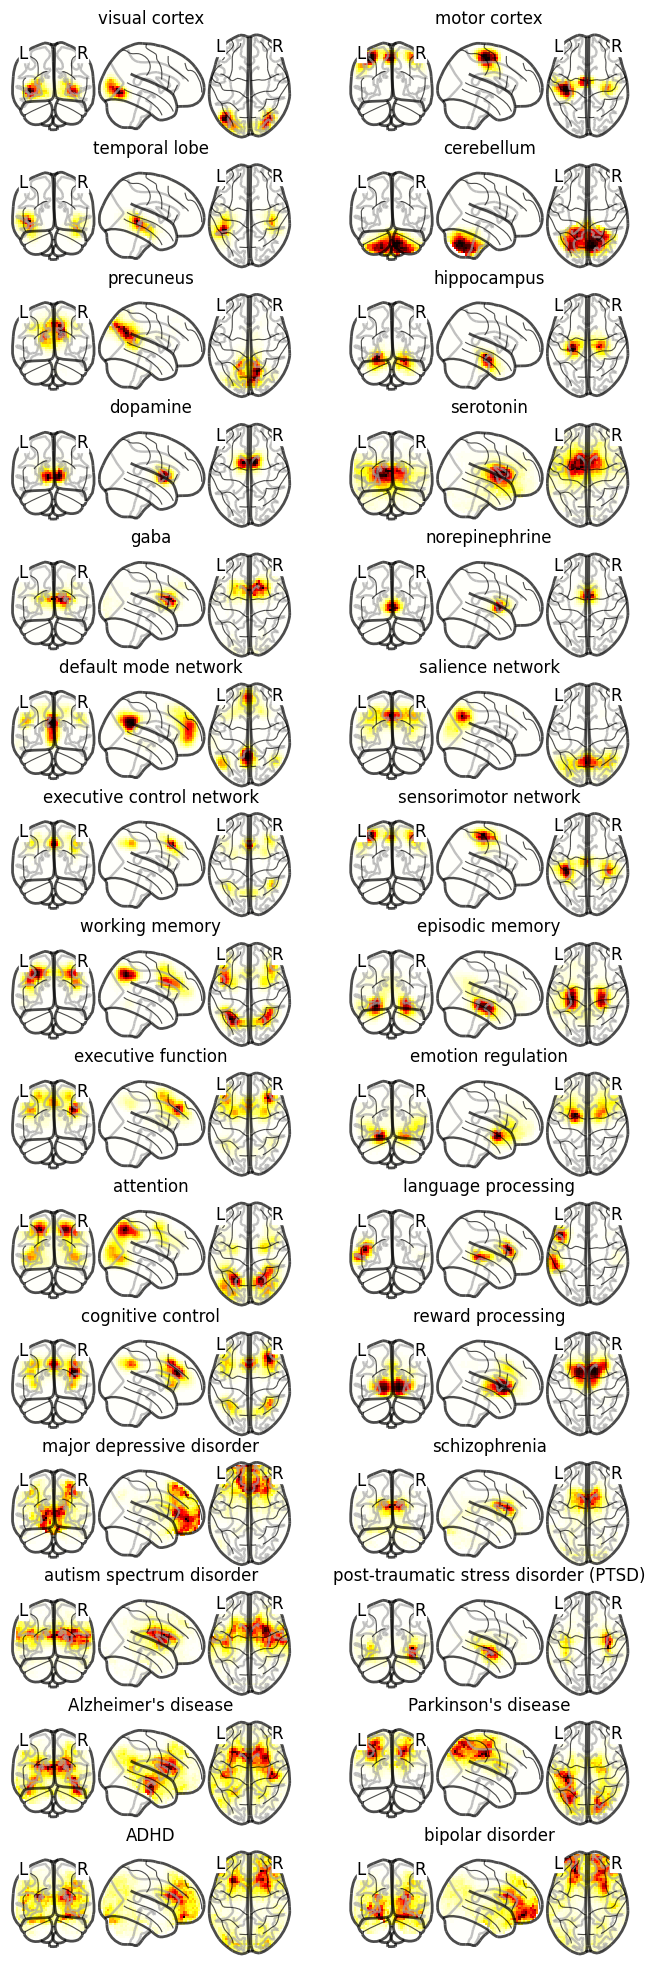

In [8]:
# Load mask
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask = mask_arrays["mask"]
affine = mask_arrays["affine"]

# Query
decoder = autoencoder.decoder.to("cpu")

fig, axes = plt.subplots(nrows=15, ncols=2, figsize=(8, 25))
axes = axes.flatten()

for i, query in enumerate(queries):

    # Encode text
    encoded_text_specter = specter(query)
    encoded_text_specter = encoded_text_specter / encoded_text_specter.norm()

    # Projection head
    aligned_text_specter = proj_head.to("cpu")(encoded_text_specter)

    # Decode brain
    neuro_pred = torch.sigmoid(decoder(aligned_text_specter)).detach().numpy()[0]

    # Plot
    pred = np.zeros(mask.shape)
    pred[mask] = neuro_pred
    img = nib.Nifti1Image(pred, affine)
    plot_glass_brain(img, threshold=0, axes=axes[i])
    axes[i].set_title(query)